# Why CNNs preferred over ANNs for Images

1.  To capture spatial information whcih cant be captured by ANNs.

2. Weights are shared so the same information if appearing on different locations can still be captured.

3. Later layers of CNNs are able to capture much more receptive field because of convolutions. Each cell for later layer corresponds to more cells in original image.

4. Number of parameters required is way less in CNNs.

5. Saves us from image translation issues. Initially the ANN might work but if you translate the image (move object in image left or right), ANNs fail here. CNNs help here. To strengthen it further we can use image augmentation



# CNN on toy dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],[5,6,7,8],[1,3,4,5]]],[[[-1,2,3,-4],[2,-3,4,5],[-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()

In [3]:
X_train.shape

torch.Size([2, 1, 4, 4])

In [4]:
X_train[0].permute(1,2,0).shape   ##### pytorch expects the img data to be in the format of C*H*W

torch.Size([4, 4, 1])

In [5]:
X_train[0].squeeze(0).shape  ## for greyscale images, there should be only 2 dimensions. 

torch.Size([4, 4])

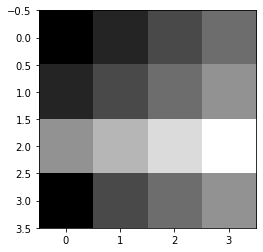

In [6]:
plt.imshow(X_train[0].squeeze(0).to("cpu"), cmap="gray")

In [7]:
### normalizing
X_train.max()

tensor(8., device='cuda:0')

In [8]:
X_train = X_train/8

In [9]:
y_train = torch.tensor([0,1]).to(device).float()

In [10]:
y_train.shape

torch.Size([2])

In [11]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

In [12]:
nn.MaxPool2d?

Init signature:
nn.MaxPool2d(
    kernel_size: Union[int, Tuple[int, ...]],
    stride: Union[int, Tuple[int, ...], NoneType] = None,
    padding: Union[int, Tuple[int, ...]] = 0,
    dilation: Union[int, Tuple[int, ...]] = 1,
    return_indices: bool = False,
    ceil_mode: bool = False,
) -> None
Docstring:     
Applies a 2D max pooling over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
can be precisely described as:

.. math::
    \begin{aligned}
        out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
                                & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
                                               \text{stride[1]} \times w + n)
    \end{aligned}

If :attr:`padding` is non-zero, then the input is implicitly padded with negative infinity on both

In [13]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3), # (4 x 4) conv (3 x3) ====> 2 x 2
        nn.MaxPool2d(2), # (2 x 2) max pool === > 1 x 1
        nn.ReLU(), 
        nn.Flatten(),
        nn.Linear(1,1),
        nn.Sigmoid() ### using BCE loss hence applying
          
    ).to(device)
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    
    return model, loss_fn, optimizer

In [14]:
import torchsummary

In [15]:
from torchsummary import summary

In [16]:
summary?

Signature:
summary(
    model: torch.nn.modules.module.Module,
    input_data: Union[torch.Tensor, torch.Size, Sequence[torch.Tensor], Sequence[Union[int, Sequence[Any], torch.Size]], NoneType] = None,
    *args: Any,
    batch_dim: Union[int, NoneType] = 0,
    branching: bool = True,
    col_names: Union[Iterable[str], NoneType] = None,
    col_width: int = 25,
    depth: int = 3,
    device: Union[torch.device, NoneType] = None,
    dtypes: Union[List[torch.dtype], NoneType] = None,
    verbose: int = 1,
    **kwargs: Any,
) -> torchsummary.model_statistics.ModelStatistics
Docstring:
Summarize the given PyTorch model. Summarized information includes:
    1) Layer names,
    2) input/output shapes,
    3) kernel shape,
    4) # of parameters,
    5) # of operations (Mult-Adds)

Args:
    model (nn.Module):
            PyTorch model to summarize. The model should be fully in either train()
            or eval() mode. If layers are not all in the same mode, running summary
            

In [17]:
model, loss_fn, optimizer = get_model()

In [18]:
summary(model, X_train)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [19]:
def train_batch(x, y, model , loss_fn,optimizer):
    model.train()
    loss = loss_fn(model(x),y) ## _y, y passed
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
    
    

In [20]:
TensorDataset?

Init signature: TensorDataset(*args, **kwds)
Docstring:     
Dataset wrapping tensors.

Each sample will be retrieved by indexing tensors along the first dimension.

Args:
    *tensors (Tensor): tensors that have the same size of the first dimension.
File:           c:\users\rachi\anaconda3\lib\site-packages\torch\utils\data\dataset.py
Type:           type
Subclasses:     


In [21]:
trn_dl = DataLoader(TensorDataset(X_train, y_train))

In [22]:
losses = []
for epoch in range(2000):
    epoch_loss = []
    for ix, batch in enumerate(iter(trn_dl)):
        
        
        x, y = batch
        
        y = y.view(-1,1)
        # print(y.shape)
        batch_loss = train_batch(x,y, model, loss_fn, optimizer)
        epoch_loss.append(batch_loss)

    
    
    losses.append(np.array(epoch_loss).mean())

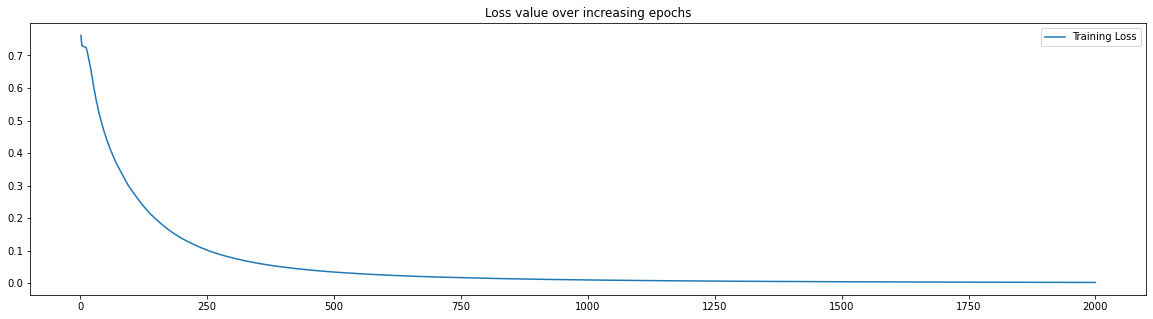

In [23]:
epochs = np.arange(2000)+1
plt.figure(figsize=(20,5))

plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

plt.show()

In [24]:
model(X_train[1])

tensor([[0.9956]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [25]:
y_train

tensor([0., 1.], device='cuda:0')

##### Checking How CNNs wok: Not needed for model training

###### Extracting weights from CNN

In [26]:
list(model.children())[0].weight.data

tensor([[[[0.9898, 0.1854, 1.3433],
          [1.1790, 0.4026, 0.0608],
          [1.2609, 1.3599, 0.8753]]]], device='cuda:0')

In [27]:
hasattr(list(model.children())[0],'weight')

True

In [28]:
(cnn_w, cnn_b) ,(lin_w, lin_b) = [(layer.weight.data, layer.bias.data) for layer in list(model.children()) if hasattr(layer,'weight')]

In [29]:
cnn_w

tensor([[[[0.9898, 0.1854, 1.3433],
          [1.1790, 0.4026, 0.0608],
          [1.2609, 1.3599, 0.8753]]]], device='cuda:0')

In [30]:
cnn_b

tensor([-0.0741], device='cuda:0')

In [31]:
cnn_w.shape  # batch_size, channels, height, width

torch.Size([1, 1, 3, 3])

In [32]:
h_im, w_im = X_train.shape[2:]
h_conv, w_conv = cnn_w.shape[2:]

sumprod = torch.zeros((h_im-h_conv + 1), (w_im - w_conv +1 ))   ## Creating blank feature map

In [33]:
sumprod

tensor([[0., 0.],
        [0., 0.]])

In [34]:
sumprod.shape

torch.Size([2, 2])

In [35]:
for i in range(sumprod.shape[1]):  ## row
    for j in range(sumprod.shape[0]):  ## column
        img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
        
        ##print(img_subset.shape) ## 3 x 3
        model_filter = cnn_w.reshape((3,3))
        
        ## convolving
        val = torch.sum(img_subset*model_filter) + cnn_b
        sumprod[i,j] = val
        

In [36]:
np.array(sumprod).shape

(2, 2)

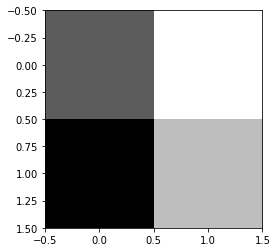

In [37]:
plt.imshow(np.array(sumprod), cmap = "gray")

In [38]:
sumprod.clamp_min_(0) ## Performs RELU

tensor([[3.6498, 4.6069],
        [3.1118, 4.2266]])

## Classifying images using deep CNNs

In [39]:
fmnsit_path = "2\data\MNIST"

In [40]:
tr_fmnist = datasets.FashionMNIST(fmnsit_path, train=True)

In [41]:
tr_images = tr_fmnist.data
tr_targets = tr_fmnist.targets

In [42]:
tr_images.shape

torch.Size([60000, 28, 28])

In [43]:
val_fmnist = datasets.FashionMNIST(fmnsit_path, train=False)

In [44]:
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [45]:
val_images.shape

torch.Size([10000, 28, 28])

In [46]:
class FMNISTdataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28) ## batch size, channels, height, width
        self.x , self.y = x, y
    
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)
    

In [47]:
def get_model():
   model = nn.Sequential(
       nn.Conv2d(1, 64, kernel_size=3),
       nn.MaxPool2d(2),
       nn.ReLU(), # 64 * 13 * 13 
       nn.Conv2d(64, 128, kernel_size=3),
       nn.MaxPool2d(2),
       nn.ReLU(),  # 128 * 5 * 5
       nn.Flatten(),
       nn.Linear(3200, 256),
       nn.ReLU(),
       nn.Linear(256, 10)
    ).to(device)
    
   optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
   loss_fn = nn.CrossEntropyLoss() 
   
   return model, loss_fn, optimizer    
    

In [48]:
def train_batch(x,y, model,  optimizer, loss_fn):
    
    model.train()
    _y = model(x)
    batch_loss = loss_fn(_y,y)
    
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()
    
    

In [49]:
@torch.no_grad()
def accuracy(x,y, model):
    model.eval()
    prediction = model(x)
    
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y 
    return is_correct.cpu().numpy().tolist()

In [50]:
def get_data():
    trn_dataset = FMNISTdataset(tr_images, tr_targets)
    trn_dl = DataLoader(trn_dataset, batch_size=32, shuffle=True)
    
    val_dataset = FMNISTdataset(val_images, val_targets)
    val_dl = DataLoader(val_dataset, batch_size=len(val_images), shuffle=False)
    
    return trn_dl, val_dl
    

In [51]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction,y)
    return val_loss.item()

In [52]:
trn_dl, val_dl = get_data()

In [53]:
model, loss_fn, optimizer = get_model()

In [54]:
summary(model, torch.zeros((1,1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [55]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [],[]
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x,y,model,optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.array(train_epoch_accuracies).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Current training loss: {train_epoch_loss}")
    print(f"Current training accuracy: {train_epoch_accuracy}")
    print(f"Current validation loss: {validation_loss}")
    print(f"Current validation accuracy: {val_epoch_accuracy}")
    


epoch: 0
Current training loss: 0.4384174445549647
Current training accuracy: 0.8832166666666666
Current validation loss: 0.349861741065979
Current validation accuracy: 0.8765
epoch: 1
Current training loss: 0.2864662184158961
Current training accuracy: 0.9099
Current validation loss: 0.27949070930480957
Current validation accuracy: 0.8967
epoch: 2
Current training loss: 0.2392560359785954
Current training accuracy: 0.9156666666666666
Current validation loss: 0.2821161448955536
Current validation accuracy: 0.8983
epoch: 3
Current training loss: 0.20584290372828642
Current training accuracy: 0.9319333333333333
Current validation loss: 0.252566933631897
Current validation accuracy: 0.9055
epoch: 4
Current training loss: 0.1785442251801491
Current training accuracy: 0.94885
Current validation loss: 0.23756715655326843
Current validation accuracy: 0.9169


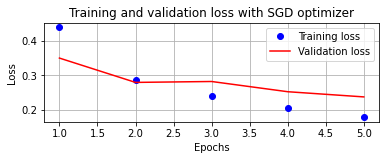

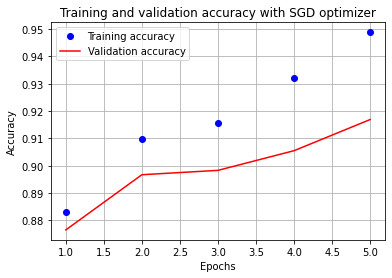

In [56]:
epochs = np.arange(5)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.grid('off')
plt.show()



### Predictions after performing translations

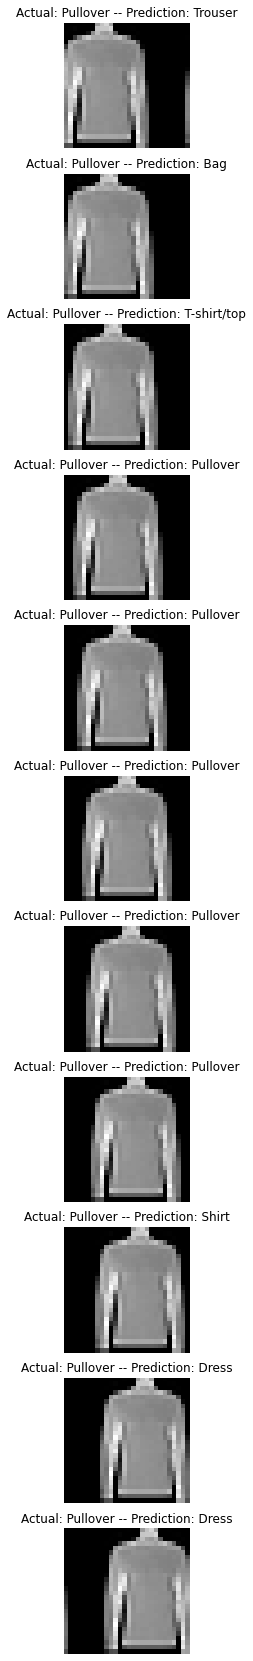

In [57]:
preds = []
ix = 4300

plt.figure(figsize=(30,30))
for px in range(-5,6):
    img = val_images[ix]/255
    
    img = img.view(28,28) ### greyscale image
    
    img2 = np.roll(img, px, axis=1)
    img3 =torch.tensor(img2).view(-1,1,28,28).to(device).float()
    
    np_output = model(img3).cpu().detach().numpy()
    
    pred = np.exp(np_output) / np.sum(np.exp(np_output))
    
    preds.append(pred)

    plt.subplot(11,1,px+6)
    plt.title(f"Actual: {val_fmnist.classes[val_targets[ix]]} -- Prediction: {val_fmnist.classes[pred[0].argmax()]}")
    plt.axis("off")
    plt.imshow(img2, cmap="gray")


In [58]:
val_targets[ix]

tensor(2)

In [59]:
val_fmnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [60]:

val_fmnist.classes[val_targets[ix]]

'Pullover'

### We are able to counter translations to some extent but its still not perfect

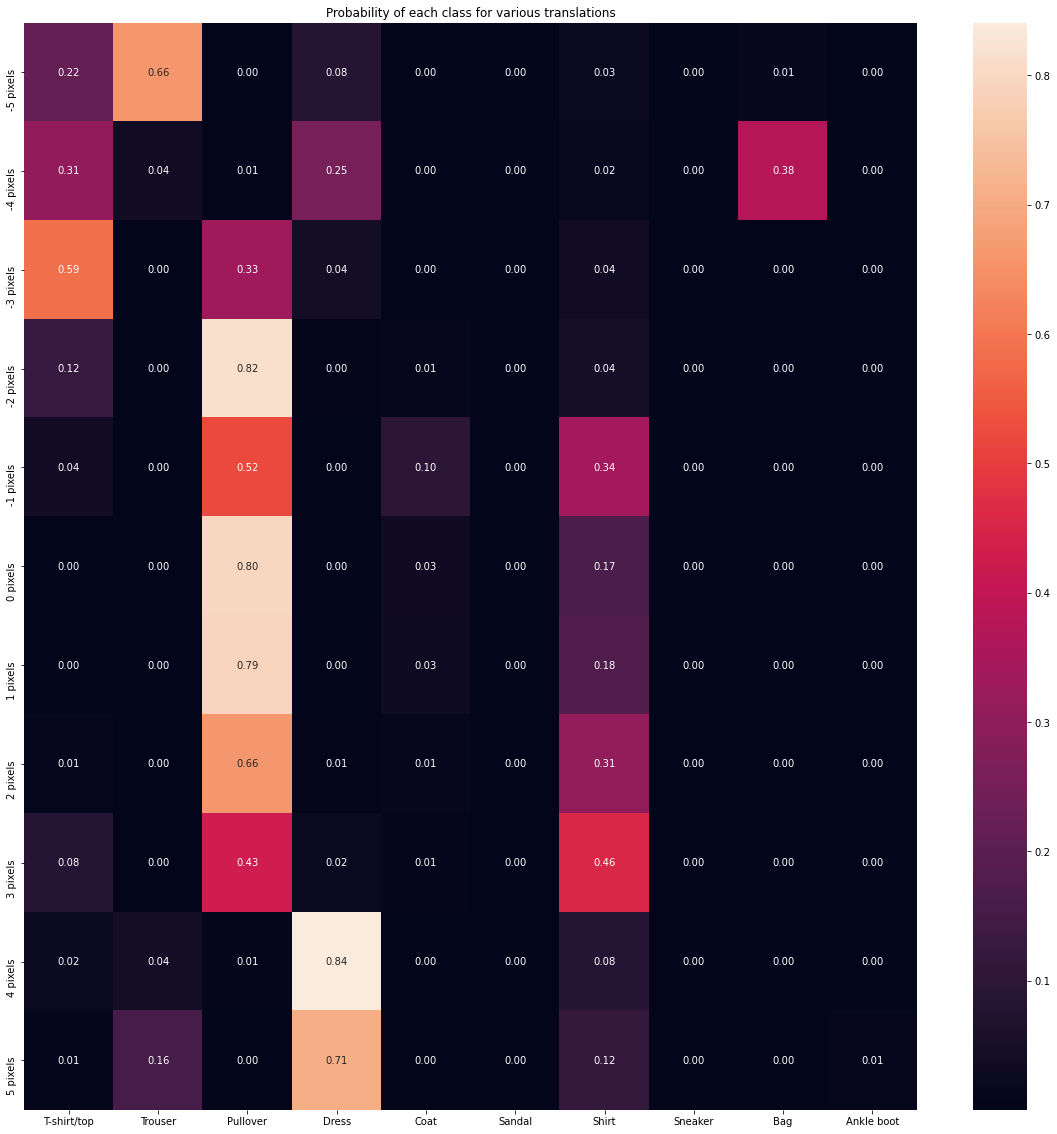

In [61]:
plt.figure(figsize=(20,20))
sns.heatmap(np.array(preds).reshape(11,10), annot =True, fmt = '.2f', xticklabels=tr_fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)])
plt.title('Probability of each class for various translations')
plt.show()

### How to sort above problem:

Train the network ion translated images. Can be done via image augmentation.

We will have to decide ourselves, what kind of data augmentation we want.


# Data Augmentation

##### Various ways in which real life images might be different than images in our dataset

1. Images are rotated slightly

2. Images are zoomed in/out (scaled)

3. Some amount of noise is present in image

4. Images have low brightness

5. Images have been flipped

6. Images have been sheared (one side of image is more twisted)


A neural network should take care of above considerations.



In [62]:
### can use augmentors library
### pytorch transforms library can also be used but it has less capabilities compared to augmentors 

In [63]:
from torchvision import transforms

In [64]:
print(dir(transforms))

['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'ElasticTransform', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'TenCrop', 'ToPILImage', 'ToTensor', 'TrivialAugmentWide', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_pil_constants', '_presets', 'autoaugment', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


In [65]:
import imgaug.augmenters as iaa
import imgaug

In [66]:
imgaug.__version__

'0.4.0'

In [67]:
print(dir(iaa)) ### clearly so many more functionalities

['ABCMeta', 'Add', 'AddElementwise', 'AddToBrightness', 'AddToHue', 'AddToHueAndSaturation', 'AddToSaturation', 'AdditiveGaussianNoise', 'AdditiveLaplaceNoise', 'AdditivePoissonNoise', 'Affine', 'AffineCv2', 'AllChannelsCLAHE', 'AllChannelsHistogramEqualization', 'Alpha', 'AlphaElementwise', 'AssertLambda', 'AssertShape', 'Augmenter', 'AverageBlur', 'AveragePooling', 'Batch', 'BilateralBlur', 'BlendAlpha', 'BlendAlphaBoundingBoxes', 'BlendAlphaCheckerboard', 'BlendAlphaElementwise', 'BlendAlphaFrequencyNoise', 'BlendAlphaHorizontalLinearGradient', 'BlendAlphaMask', 'BlendAlphaRegularGrid', 'BlendAlphaSegMapClassIds', 'BlendAlphaSimplexNoise', 'BlendAlphaSomeColors', 'BlendAlphaVerticalLinearGradient', 'BoundingBoxesMaskGen', 'CLAHE', 'CSPACE_ALL', 'CSPACE_BGR', 'CSPACE_CIE', 'CSPACE_GRAY', 'CSPACE_HLS', 'CSPACE_HSV', 'CSPACE_Lab', 'CSPACE_Luv', 'CSPACE_RGB', 'CSPACE_YCrCb', 'CSPACE_YUV', 'Canny', 'Cartoon', 'CenterCropToAspectRatio', 'CenterCropToFixedSize', 'CenterCropToMultiplesOf', 

In [68]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

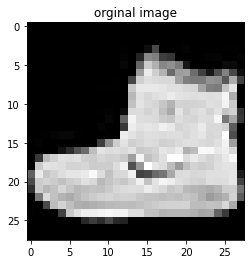

In [69]:
plt.imshow(tr_images[0], cmap = "gray")
plt.title('orginal image')
plt.show()

### Augmentations with augmentors library

##### Approach:


1. Define object that will perform scaling

2. Specvify that we want to augment image with augment_image method


### 1. Affine Transformations 

In [70]:
iaa.Affine?

Init signature:
iaa.Affine(
    scale=None,
    translate_percent=None,
    translate_px=None,
    rotate=None,
    shear=None,
    order=1,
    cval=0,
    mode='constant',
    fit_output=False,
    backend='auto',
    seed=None,
    name=None,
    random_state='deprecated',
    deterministic='deprecated',
)
Docstring:     
Augmenter to apply affine transformations to images.

This is mostly a wrapper around the corresponding classes and functions
in OpenCV and skimage.

Affine transformations involve:

    - Translation ("move" image on the x-/y-axis)
    - Rotation
    - Scaling ("zoom" in/out)
    - Shear (move one side of the image, turning a square into a trapezoid)

All such transformations can create "new" pixels in the image without a
defined content, e.g. if the image is translated to the left, pixels
are created on the right.
A method has to be defined to deal with these pixel values. The
parameters `cval` and `mode` of this class deal with this.

Some transformations involv

##### zoomed in

In [71]:
aug = iaa.Affine(scale=2)  ### zooms in by 2x

Text(0.5, 1.0, 'Scaled Image')

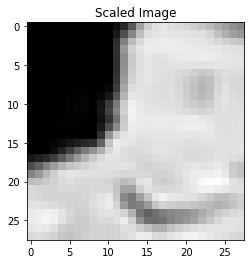

In [72]:
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')  
### input needs to be numpy array 
plt.title('Scaled Image')

##### Translated 

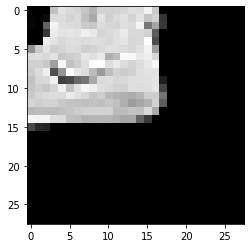

In [73]:
aug = iaa.Affine(translate_px=-10)  ### by -10
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

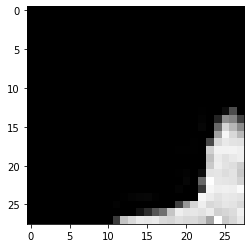

In [74]:
aug = iaa.Affine(translate_px=10)   ### by +10
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

In [75]:
### Different translation in x and y direction

aug = iaa.Affine(translate_px={'x':5,'y':-7})

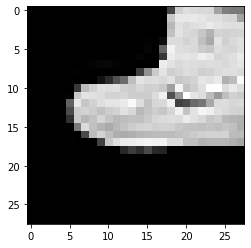

In [76]:
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = 'gray')

##### Rotation

In [77]:
aug = iaa.Affine(rotate=-45)

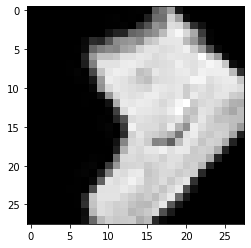

In [78]:
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = 'gray')

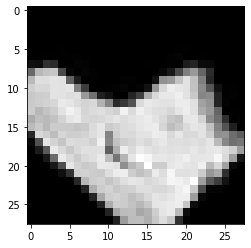

In [79]:
aug = iaa.Affine(rotate=45)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = 'gray')

In [80]:
aug = iaa.Affine(shear=30)

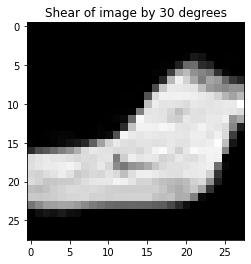

In [81]:
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray")
plt.title(f'Shear of image by 30 degrees')
plt.show()

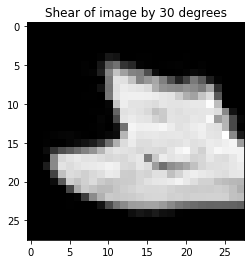

In [82]:
aug = iaa.Affine(shear=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray")
plt.title(f'Shear of image by 30 degrees')
plt.show()

#### In the preceeding outputs, some pixels get trimmed out. Lets see how we can pad with dummy data to avoid such scenario. 

In [83]:
### fit_output is a parameter that can be utilized 

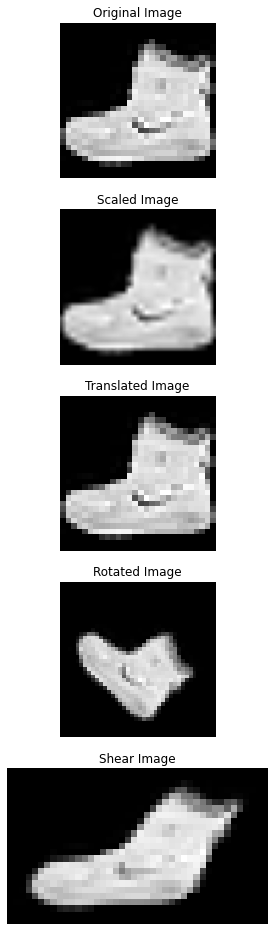

In [84]:
plt.figure(figsize=(20,20))


#### original image
plt.subplot(6,1,1)
plt.imshow(tr_images[0], cmap='gray')
plt.title(f'Original Image')
plt.axis("off")


#### Scaled Image
plt.subplot(6,1,2)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Scaled Image')
plt.axis("off")



#### Translation
plt.subplot(6,1,3)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Translated Image')
plt.axis("off")



#### Rotation
plt.subplot(6,1,4)
aug = iaa.Affine(rotate=45, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Rotated Image')
plt.axis("off")


#### Shear Image
plt.subplot(6,1,5)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Shear Image')
plt.axis("off")


plt.show()

#### cval parameters : how to fill the padded pixels

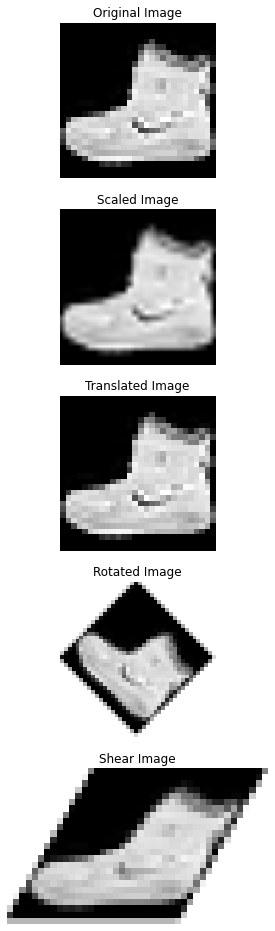

In [85]:
plt.figure(figsize=(20,20))


#### original image
plt.subplot(6,1,1)
plt.imshow(tr_images[0], cmap='gray')
plt.title(f'Original Image')
plt.axis("off")


#### Scaled Image
plt.subplot(6,1,2)
aug = iaa.Affine(scale=2, fit_output=True, cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Scaled Image')
plt.axis("off")



#### Translation
plt.subplot(6,1,3)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True, cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Translated Image')
plt.axis("off")



#### Rotation
plt.subplot(6,1,4)
aug = iaa.Affine(rotate=45, fit_output=True, cval = 255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Rotated Image')
plt.axis("off")


#### Shear Image
plt.subplot(6,1,5)
aug = iaa.Affine(shear=30, fit_output=True, cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title(f'Shear Image')
plt.axis("off")


plt.show()


### have filled up with white pixels, by default 0 is added while augmenting.

##### Can pad with different modes


1. constant
2. edge
3. symmetric
4. reflect
5. wrap


#### Specifying range to perform rotation

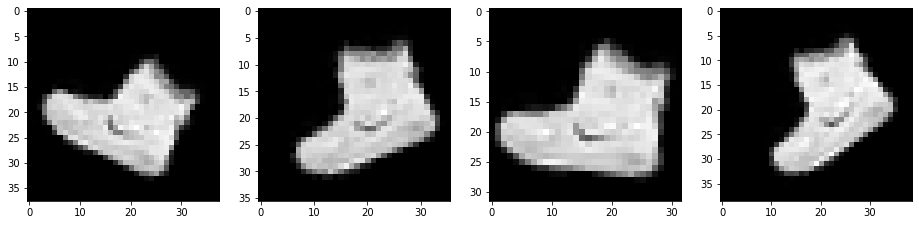

In [86]:


plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')



### specifying range for translation

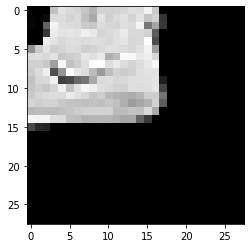

In [87]:
aug = iaa.Affine(translate_px=(-15,15), mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

## Changing Brightness:

Really helps when foreground and background are not that distinct.

Two ways:

1. Multiply: multiply each pixel by a given value.

2. LinearContrast: adjusts each pixel on the basis of the given formula:
            
            127 + alpha*(pixel_value - 127). 
            
            If alpha < 1, then low pixel values are increased and high pixel values are reduced

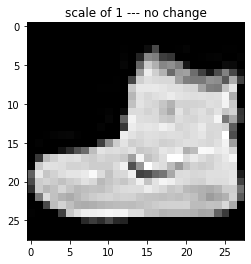

In [88]:
aug = iaa.Multiply(1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin = 0, vmax =255)
plt.title("scale of 1 --- no change")
plt.show()

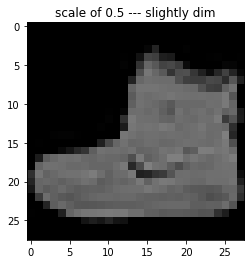

In [89]:
aug = iaa.Multiply(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin=0, vmax = 255)
plt.title("scale of 0.5 --- slightly dim")
plt.show()

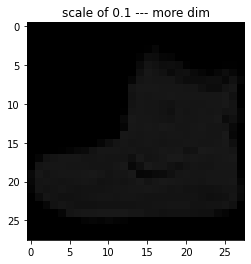

In [90]:
aug = iaa.Multiply(0.1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin = 0, vmax = 255)
plt.title("scale of 0.1 --- more dim")
plt.show()

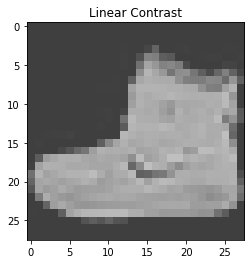

In [91]:
aug = iaa.LinearContrast(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin = 0, vmax = 255)
plt.title("Linear Contrast")
plt.show()

In [92]:
###### vmin: min data value, vmax: max data value

### Gaussian Blur

This is a a realistic scenario where image can be blurred due to motion

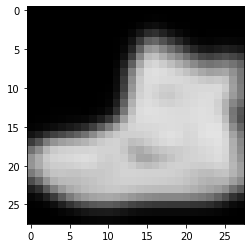

In [93]:
aug = iaa.GaussianBlur(1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin = 0, vmax = 255)

plt.show()


In [94]:
iaa.GaussianBlur?

Init signature:
iaa.GaussianBlur(
    sigma=(0.0, 3.0),
    seed=None,
    name=None,
    random_state='deprecated',
    deterministic='deprecated',
)
Docstring:     
Augmenter to blur images using gaussian kernels.

**Supported dtypes**:

See ``~imgaug.augmenters.blur.blur_gaussian_(backend="auto")``.

Parameters
----------
sigma : number or tuple of number or list of number or imgaug.parameters.StochasticParameter, optional
    Standard deviation of the gaussian kernel.
    Values in the range ``0.0`` (no blur) to ``3.0`` (strong blur) are
    common.

        * If a single ``float``, that value will always be used as the
          standard deviation.
        * If a tuple ``(a, b)``, then a random value from the interval
          ``[a, b]`` will be picked per image.
        * If a list, then a random value will be sampled per image from
          that list.
        * If a ``StochasticParameter``, then ``N`` samples will be drawn
          from that parameter per ``N`` input images.


## Adding noise

In real world, we can get grainy pictures due to bad photography. 

To replicate this, we can use dropout and salt and peeper

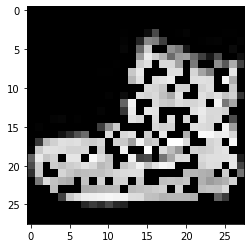

In [95]:
### Dropout

aug = iaa.Dropout(0.25)  ## randomly selects pixels that should be made inactive(black)

plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin = 0, vmax = 255)

plt.show()


In [96]:
## Salt and pepper: Adds randomly whitish and blackish pixels


iaa.SaltAndPepper?

Init signature:
iaa.SaltAndPepper(
    p=(0.0, 0.03),
    per_channel=False,
    seed=None,
    name=None,
    random_state='deprecated',
    deterministic='deprecated',
)
Docstring:     
Replace pixels in images with salt/pepper noise (white/black-ish colors).

**Supported dtypes**:

See :class:`~imgaug.augmenters.arithmetic.ReplaceElementwise`.

Parameters
----------
p : float or tuple of float or list of float or imgaug.parameters.StochasticParameter, optional
    Probability of replacing a pixel to salt/pepper noise.

        * If a float, then that value will always be used as the
          probability.
        * If a tuple ``(a, b)``, then a probability will be sampled
          uniformly per image from the interval ``[a, b]``.
        * If a list, then a random value will be sampled from that list
          per image.
        * If a ``StochasticParameter``, then a image-sized mask will be
          sampled from that parameter per image. Any value ``>0.5`` in
          that mask 

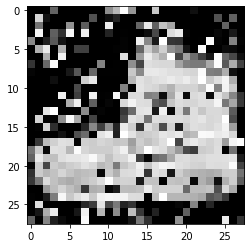

In [97]:
aug = iaa.SaltAndPepper(0.3)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap = "gray", vmin = 0, vmax = 255)

plt.show()


# Sequence of Augmentations

In [98]:
seq = iaa.Sequential(
    [
        iaa.Dropout(0.1),
        iaa.Affine(translate_px=(-10,10))
    ],
    random_order =True
)

In [99]:
### random_order == True specifies that transformation will be applied randomly

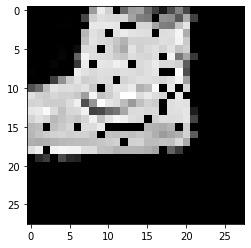

In [100]:
plt.imshow(seq.augment_image(to_numpy(tr_images[0])), cmap = "gray")
plt.show()

# Augmentation for model training

output of augmentatu=ion: numpy array

Two options:

1. At runtime ----> will use it here, randomly generates augmentations, to make the model learn better. __getitem_ method
2. Before runtime ----> Can help us if we have imbalanced dataset. __init_ method.


Runtime Augmentation:

1. One image at a time: Very time consuming

2. Augmenting batch of images: can be ||ised. Faster.

    __getitem_ method returns index of single element only. To operate on batch of images, we utilise colate fn.


##### Writing collate fn

In [101]:
class FMNISTdataset(Dataset):
    
    def __init__(self,x,y, aug =None): ## Notice aug, this specifies which augmentation pipeline should be used. None means, we will not use data augmentation
        self.x = x
        self.y = y
        self.aug = aug
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index].to(device), self.y[index].to(device)
    
    
    #### This is new
    def collate_fn(self, batch):
        ## seperate img and classes as augmentation only to be applied on image
        ims , classes = list(zip(*batch))
        if self.aug: ### only apply if augmentation object has been provided. Will be passed from dataloader
            ims = self.aug.augment_images(images = ims) ## augmentation, returns numpy array
            ## convert to tensor
            ims = torch.tensor(ims)[:,None,:,:].to(device)/255
            classes = torch.tensor(classes).to(device)
            return ims, classes
        
                                

    
            

In [102]:
a = [1,2,3]
b = [4,5,6]

list(zip(a,b))

[(1, 4), (2, 5), (3, 6)]

In [103]:
batch = zip([[1,2,3,4],[4,5,6,7]])

In [104]:
list(batch)

[([1, 2, 3, 4],), ([4, 5, 6, 7],)]

#### We utilize collate_fn, when we want to perform heavy computations as doing so on a batch is quicker compared to doing it 1 by 1.


Will use collate_fn while creating object of dataset. Will always have to pass collate_fn arguement in Dataloader if going via this route

# Data Augmentation on FMNIST 

In [105]:
import imgaug
from imgaug import augmenters as iaa

In [106]:
iaa.Sequential?

Init signature:
iaa.Sequential(
    children=None,
    random_order=False,
    seed=None,
    name=None,
    random_state='deprecated',
    deterministic='deprecated',
)
Docstring:     
List augmenter containing child augmenters to apply to inputs.

This augmenter is simply a list of other augmenters. To augment an image
or any other data, it iterates over its children and applies each one
of them independently to the data. (This also means that the second
applied augmenter will already receive augmented input data and augment
it further.)

This augmenter offers the option to apply its children in random order
using the `random_order` parameter. This should often be activated as
it greatly increases the space of possible augmentations.

.. note::

    You are *not* forced to use :class:`~imgaug.augmenters.meta.Sequential`
    in order to use other augmenters. Each augmenter can be used on its
    own, e.g the following defines an augmenter for horizontal flips and
    then augments a s

In [107]:
aug = iaa.Sequential(
    [
        iaa.Affine(translate_px={'x':(-10,10)}, mode='constant')
    ]
    
)

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [109]:
device

'cuda'

In [238]:
class FMNISTdataset(Dataset):
    def __init__(self, x, y, aug = None):
        # self.x = x.float()/255
        #self.x - self.x.view(-1,1,28,28)
        self.x = x
        self.y = y
        self.aug = aug
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]  ### dont register to device here else it will be done for each element sequentially and it will waste lot of time
    
    def collate_fn(self, batch):
        ## seperate images and classes, 
        #print(list(zip(*batch)))
        
        #print(batch)
        ims, classes = list(zip(*batch)) ## ims and classes are numpy arrays
        ims = [image.numpy() for image in ims]
        classes = [class_.numpy() for class_ in classes]        
        
        
        
        
        #print(ims[0].numpy())
        
        ## apply augmentation if aug is not non
        if self.aug: 
            ims = self.aug.augment_images(images = ims)
        
        #print(len(ims))
        
        #plt.imshow(ims[1], cmap = "gray")
        #return(ims)
        ### create tensors out of numpy arrays
        
        ims = np.asarray(ims)
        classes = np.array(classes)
        
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255
        classes = torch.tensor(classes).to(device)
            
        return ims, classes
        
        
        
        #return batch    
        
        

In [239]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,64,kernel_size =3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        
        nn.Conv2d(64,128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        
        nn.Flatten(), 
        
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256,10)
        
        
    ).to(device)
    
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    
    return model, loss_fn, optimizer

In [240]:
model,loss_fn,optimizer = get_model()

In [241]:
from torchsummary import summary

In [242]:
summary(model[0], torch.zeros(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
└─Conv2d: 0-1                            [-1, 64, 26, 26]          640
Total params: 640
Trainable params: 640
Non-trainable params: 0
Total mult-adds (M): 0.39
Input size (MB): 0.00
Forward/backward pass size (MB): 0.33
Params size (MB): 0.00
Estimated Total Size (MB): 0.34


Layer (type:depth-idx)                   Output Shape              Param #
└─Conv2d: 0-1                            [-1, 64, 26, 26]          640
Total params: 640
Trainable params: 640
Non-trainable params: 0
Total mult-adds (M): 0.39
Input size (MB): 0.00
Forward/backward pass size (MB): 0.33
Params size (MB): 0.00
Estimated Total Size (MB): 0.34

In [243]:
def train_batch(x,y,model, optimizer, loss_fn):
    model.train(),
    batch_loss = loss_fn(model(x),y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

In [244]:
import torchmetrics ### install this library if not downloaded already

In [245]:
from torchmetrics.classification import MulticlassAccuracy

In [246]:
@torch.no_grad()
def accuracy(x,y,model):
    model.eval()
    prediction = model(x)
    max_values , argmaxes = prediction.max(-1)
    #print(prediction)
    
    is_correct = argmaxes==y
    #print(is_correct)
    
    return is_correct.cpu().numpy().tolist()
    

In [247]:
len(val_fmnist.classes)

10

In [248]:
@torch.no_grad()
def val_loss(x,y,model, loss_fn):
    model.eval()
    _y = model(x)
    val_loss = loss_fn(_y,y)
    return val_loss.item()

In [249]:
tr_images.shape

torch.Size([60000, 28, 28])

In [250]:
tr_images[:1].shape

torch.Size([1, 28, 28])

In [251]:
def get_data():
    train = FMNISTdataset(tr_images,tr_targets,aug = aug) ### passing aug object
    trn_dl = DataLoader(train, batch_size=64, shuffle=True, collate_fn=train.collate_fn) ### passing the collate function
    
    val = FMNISTdataset(val_images, val_targets) ## wont pass aug object
    val_dl = DataLoader(val,batch_size=len(val_images), collate_fn=val.collate_fn,shuffle=True)
    
    return trn_dl, val_dl

In [252]:
trn_dl, val_dl = get_data()

In [253]:
#aug.augment_images?

In [254]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"epoch: {epoch}")
    
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        
        batch_loss = train_batch(x,y,model, optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x,y, model)
        
        train_epoch_accuracies.extend(is_correct)
   
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x,y, model)
        validation_loss =  val_loss(x,y,model, loss_fn)

    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    
    print(f"Current loss: {train_epoch_loss}" )
    print(f"Current accuracy: {train_epoch_accuracy}")
    print(f"Current validation loss: {validation_loss}")
    print(f"Current validation accuracy: {val_epoch_accuracy}")

epoch: 0
Current loss: 0.7038687929860564
Current accuracy: 0.8123
Current validation loss: 0.5144538283348083
Current validation accuracy: 0.8128
epoch: 1
Current loss: 0.44991586899071107
Current accuracy: 0.8582833333333333
Current validation loss: 0.41976410150527954
Current validation accuracy: 0.8521
epoch: 2
Current loss: 0.3771065419226059
Current accuracy: 0.8714166666666666
Current validation loss: 0.3896057605743408
Current validation accuracy: 0.8648
epoch: 3
Current loss: 0.34126681675598314
Current accuracy: 0.8798833333333334
Current validation loss: 0.34515580534935
Current validation accuracy: 0.8742
epoch: 4
Current loss: 0.3146599826814015
Current accuracy: 0.89025
Current validation loss: 0.33103179931640625
Current validation accuracy: 0.8793


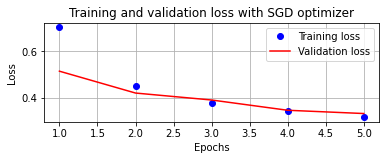

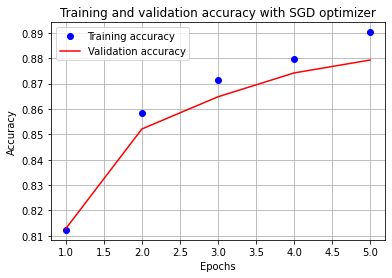

In [255]:
epochs = np.arange(5)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.grid('off')
plt.show()



## Clearly very less overfitting

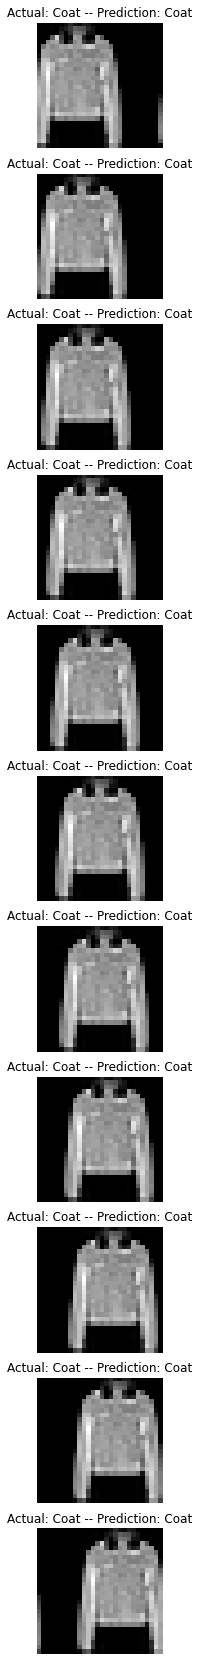

In [256]:
preds = []
ix = 4500

plt.figure(figsize=(30,30))
for px in range(-5,6):
    img = val_images[ix]/255
    
    img = img.view(28,28) ### greyscale image
    
    img2 = np.roll(img, px, axis=1)
    img3 =torch.tensor(img2).view(-1,1,28,28).to(device).float()
    
    np_output = model(img3).cpu().detach().numpy()
    
    pred = np.exp(np_output) / np.sum(np.exp(np_output))
    
    preds.append(pred)

    plt.subplot(11,1,px+6)
    plt.title(f"Actual: {val_fmnist.classes[val_targets[ix]]} -- Prediction: {val_fmnist.classes[pred[0].argmax()]}")
    plt.axis("off")
    plt.imshow(img2, cmap="gray")


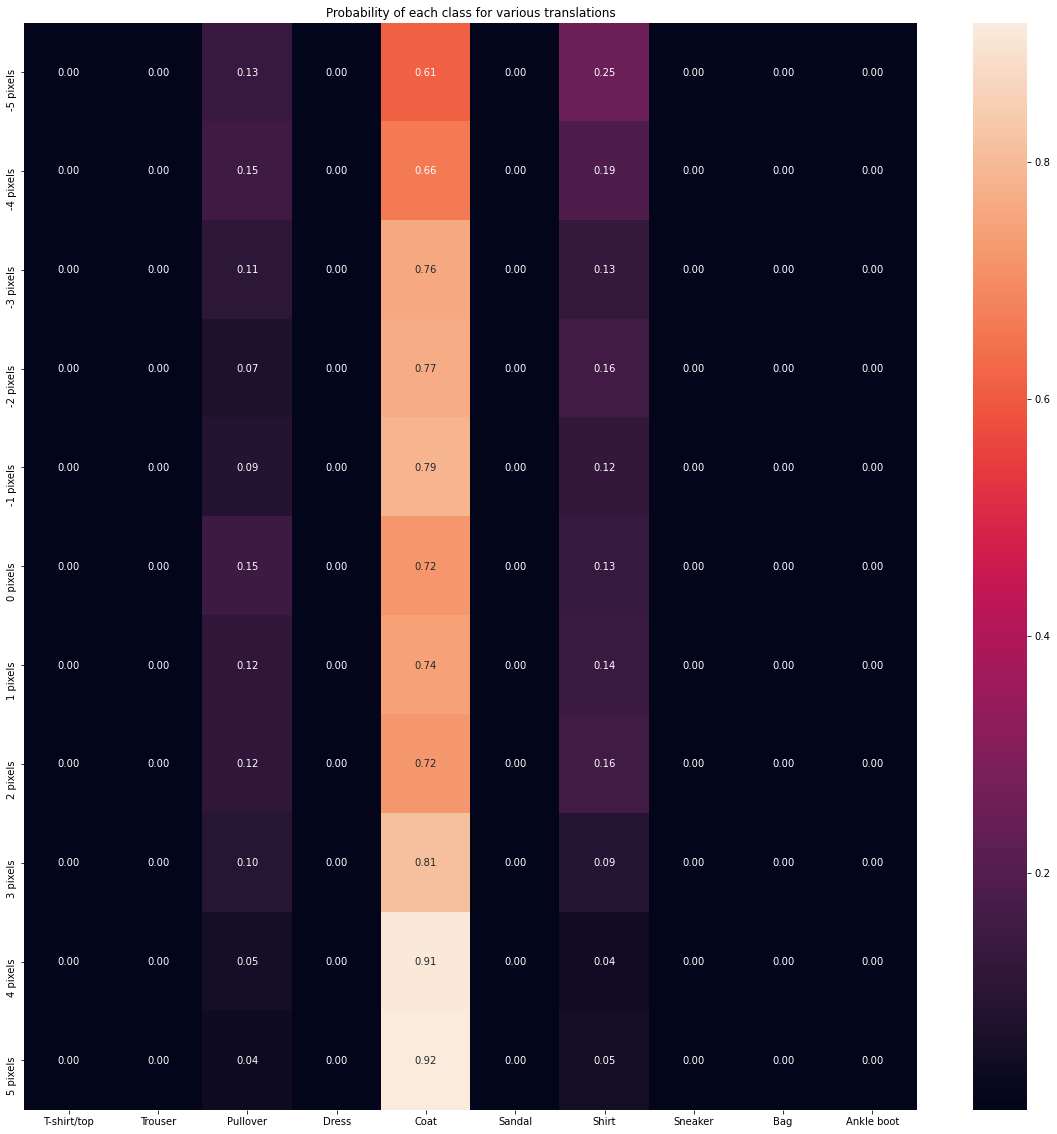

In [257]:
plt.figure(figsize=(20,20))
sns.heatmap(np.array(preds).reshape(11,10), annot =True, fmt = '.2f', xticklabels=tr_fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)])
plt.title('Probability of each class for various translations')
plt.show()

In [236]:
train2 = FMNISTdataset(tr_images[:2],tr_targets,aug = aug) ### passing aug object
trn_dl2 = DataLoader(train2, batch_size=64, shuffle=True, collate_fn=train2.collate_fn) ### passing the collate function

In [237]:
for x in enumerate(iter(trn_dl2)):
    print(x)

[(tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0, 